In [1]:
! pip install pywph==1.0

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import pywph as pw
import numpy as np
import torch

Reason for being yanked: Wrong requirements.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
params = pd.read_csv('drive/MyDrive/camels data/params.csv')
nbody_file = np.load('drive/MyDrive/camels data/Maps_Mtot_Nbody_SIMBA_LH_z=0.00.npy')

In [4]:
full_params = params.loc[params.index.repeat(15)] # from len=1000 to len=15000
full_params = full_params.to_numpy()

In [5]:
nbody_file.shape

(15000, 256, 256)

In [6]:
M = 256
N = 256
J = 7
L = 4
dn =0
wph_op = pw.WPHOp(M, N, J, L=L, dn=dn)

if torch.cuda.is_available():
    wph_op.to(0)

data = np.log(nbody_file)

In [7]:
num = 1000
wph_coeffs_1000 = np.zeros((num*15,520),dtype='complex')

for i in range(0,num):
  if i%50==0: print(i)
  test_coeff = wph_op(data[(i*15):(i*15+15)], pbc=True, norm=None)
  wph_coeffs_1000[(i*15):(i*15+15)] = test_coeff.cpu()

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


In [8]:
real_coeffs = wph_coeffs_1000.real
imag_coeffs = wph_coeffs_1000.imag
# use real part only here

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [10]:
num_samples, num_params= np.shape(full_params)
num_samples, num_coeffs = np.shape(real_coeffs)
params_train, params_test, coeffs_train, coeffs_test = train_test_split(full_params, real_coeffs,
                                                                    test_size=0.1, random_state=42)

In [11]:
model = keras.Sequential([
    layers.Input(shape=(num_params,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_coeffs)
])

In [12]:
model.compile(loss='mean_squared_error', optimizer='adam')
train = model.fit(params_train, coeffs_train, epochs=50, batch_size=16, validation_data=(params_test, coeffs_test))


Epoch 1/50
844/844 [==============================] - 8s 3ms/step - loss: 1.3911 - val_loss: 1.2722
Epoch 2/50
844/844 [==============================] - 2s 2ms/step - loss: 1.2667 - val_loss: 1.2264
Epoch 3/50
844/844 [==============================] - 2s 3ms/step - loss: 1.2224 - val_loss: 1.1827
Epoch 4/50
844/844 [==============================] - 2s 3ms/step - loss: 1.1887 - val_loss: 1.1534
Epoch 5/50
844/844 [==============================] - 2s 2ms/step - loss: 1.1623 - val_loss: 1.1324
Epoch 6/50
844/844 [==============================] - 2s 3ms/step - loss: 1.1450 - val_loss: 1.1135
Epoch 7/50
844/844 [==============================] - 2s 3ms/step - loss: 1.1314 - val_loss: 1.1009
Epoch 8/50
844/844 [==============================] - 2s 3ms/step - loss: 1.1203 - val_loss: 1.0956
Epoch 9/50
844/844 [==============================] - 2s 3ms/step - loss: 1.1105 - val_loss: 1.0822
Epoch 10/50
844/844 [==============================] - 2s 3ms/step - loss: 1.1029 - val_loss: 1.0824

In [13]:
loss = train.history['loss'] # loss
val_loss = train.history['val_loss'] # validation loss

Text(0, 0.5, 'validation loss')

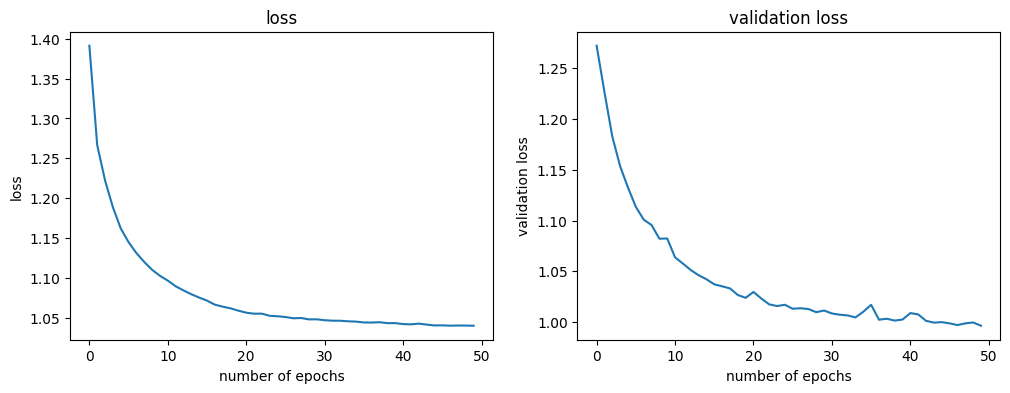

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(loss)
axs[1].plot(val_loss)

axs[0].set_title('loss')
axs[1].set_title('validation loss')

axs[0].set_xlabel('number of epochs')
axs[0].set_ylabel('loss')
axs[1].set_xlabel('number of epochs')
axs[1].set_ylabel('validation loss')

In [15]:
predictions = model.predict(params_test)
print(predictions.shape)
print(params_test.shape)

47/47 [==============================] - 0s 1ms/step
(1500, 520)
(1500, 6)


In [16]:
# coefficients predicted
pd.DataFrame(predictions)

,0,1,2,3,4,5,6,7,8,9,...,510,511,512,513,514,515,516,517,518,519
0,0.007770,0.006529,0.007005,0.006891,0.010853,0.008992,0.009100,0.009596,0.013519,0.012261,...,0.190558,-0.200465,0.052706,0.175952,0.052010,0.037336,0.017559,0.066714,0.008065,0.003419
1,0.010539,0.010222,0.009755,0.010584,0.016020,0.011051,0.009721,0.012214,0.019688,0.014874,...,1.195379,7.903130,0.110752,0.355322,0.266398,0.872364,0.032788,0.129645,0.028848,0.027647
2,0.009155,0.008138,0.008134,0.008697,0.013804,0.010383,0.009542,0.011557,0.017452,0.014567,...,0.748514,3.973563,0.083521,0.271598,0.164954,0.451718,0.023789,0.096511,0.015764,0.010165
3,0.009921,0.008910,0.009002,0.009570,0.014842,0.012155,0.010825,0.012841,0.018565,0.016902,...,0.542779,2.279132,0.073172,0.239112,0.119824,0.264433,0.019834,0.083471,0.010914,0.003784
4,0.006454,0.006533,0.006281,0.006387,0.010250,0.008216,0.006682,0.007427,0.011371,0.010771,...,0.219087,-0.068764,0.039822,0.148011,0.042820,0.133231,0.009971,0.056472,0.004397,-0.001869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.008911,0.007762,0.008095,0.008380,0.013283,0.010569,0.010227,0.011646,0.016997,0.014877,...,0.480206,1.936822,0.071242,0.232397,0.110945,0.222637,0.020820,0.083168,0.012008,0.006308
1496,0.008561,0.008753,0.007867,0.008848,0.015073,0.011049,0.009130,0.011069,0.017941,0.015421,...,0.508628,2.064792,0.056055,0.202260,0.093117,0.271749,0.011425,0.068662,0.007491,-0.006597
1497,0.007252,0.006322,0.006671,0.006609,0.010368,0.008623,0.008391,0.009047,0.012748,0.011705,...,0.250453,0.230423,0.054503,0.182870,0.063052,0.096080,0.017674,0.069427,0.008557,0.004343
1498,0.008307,0.007420,0.007623,0.007840,0.012260,0.009918,0.009329,0.010636,0.015330,0.013686,...,0.478566,1.934241,0.069052,0.227665,0.112175,0.251777,0.020566,0.083313,0.012007,0.007245


In [17]:
from sklearn.utils.extmath import svd_flip
def PCA(data, num_components):
    """calculate the principal components"""

    # standardise the data
    mean = np.mean(data, axis = 0)
    std = np.std(data, axis = 0)
    data_standard = (data - mean)#/std

    U,S,V = np.linalg.svd(data_standard, full_matrices=False)
    U,V = svd_flip(U,V) # flip sign to enforce deterministic output

    # project onto the new space
    data_transformed = data_standard.dot(V[:num_components].T)
    data_reduced = U[:,:num_components]*S[:num_components]

    return data_reduced


In [35]:
pcs = PCA(predictions,2)

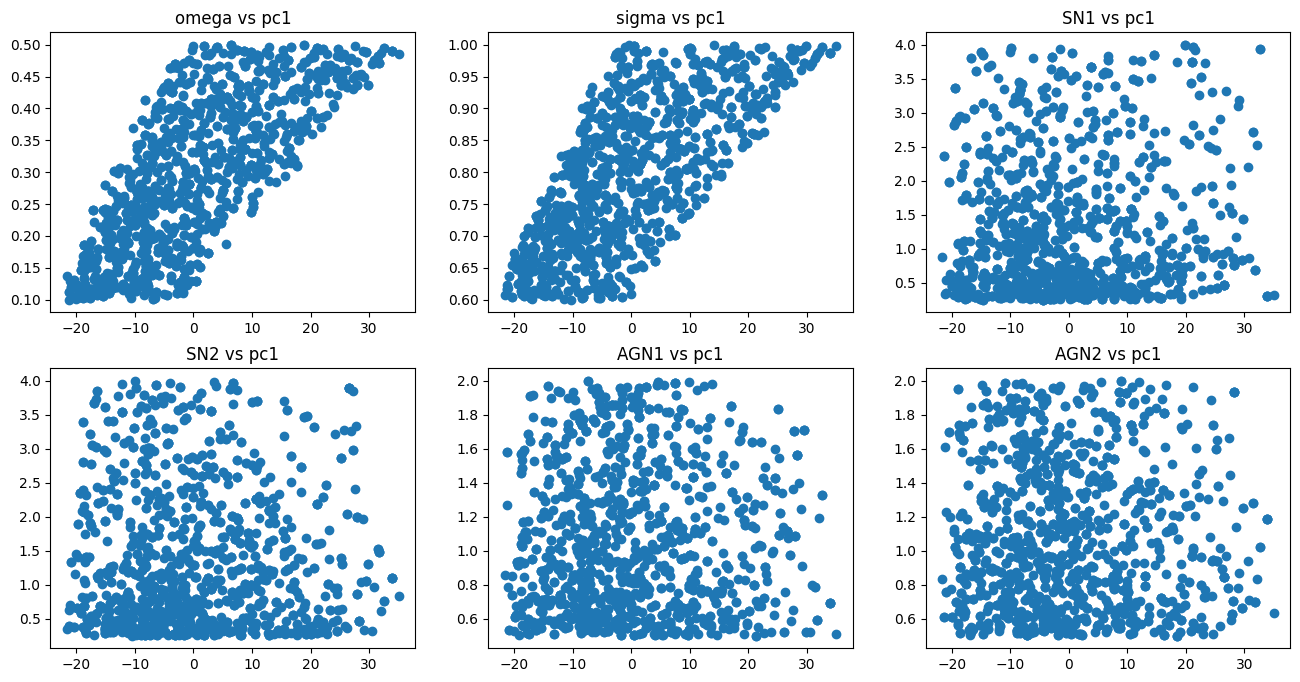

In [36]:
fig, axs = plt.subplots(2, 3, figsize=(16, 8))
axs[0,0].set_title('omega vs pc1')
axs[0,1].set_title('sigma vs pc1')
axs[0,2].set_title('SN1 vs pc1')
axs[1,0].set_title('SN2 vs pc1')
axs[1,1].set_title('AGN1 vs pc1')
axs[1,2].set_title('AGN2 vs pc1')

axs[0,0].scatter((pcs[:,0]),params_test[:,0])
axs[0,1].scatter((pcs[:,0]),params_test[:,1])
axs[0,2].scatter((pcs[:,0]),params_test[:,2])
axs[1,0].scatter((pcs[:,0]),params_test[:,3])
axs[1,1].scatter((pcs[:,0]),params_test[:,4])
axs[1,2].scatter((pcs[:,0]),params_test[:,5])

